In [1]:
import sympy as sp
sp.init_printing(use_latex ='mathjax')

import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import os
import pandas as pd
import scipy as sc
from sklearn.linear_model import LinearRegression
from lmfit import Model
import lmfit

Vivaflag = True
saving = False

In [2]:
#Define column names and read csv file

if Vivaflag:
    base1 = r"\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\ResonanceCurves"
else:
    base1 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
file1 = 'Array01.00r0.5p3Device1.2Drum1Couping500/Data.csv'

if Vivaflag:
    base2 = base1
else:
    base2 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
file2 = 'Array01.00r0.5p3Device1.2RandomNodeCoupling500/Data.csv'

path1 = os.path.join(base1, file1)
path2 = os.path.join(base2, file2)

colnames= ['SweepVal', 'F', 'R', 'theta', 'NEP_BW', 'R_ref', 'theta_ref', 'Amp', 'Phase']

df1 = pd.read_csv(path1, names = colnames)
df2 = pd.read_csv(path2, names = colnames)

In [3]:
#Fit linear part of phase lag to subtract from graph

#Define normalized data for fitting
maxR1 = df1['R'].max()
df1['Rnorm'] = (df1.R) / (maxR1)
df1['Fnorm'] = df1.F / 10**6
df1['Rnorm2']= ((df1.R)/maxR1)**2

df2['Rnorm'] = (df2.R) / (maxR1)
df2['Fnorm'] = df2.F / 10**6
df2['Rnorm2']= ((df2.R)/maxR1)**2

#Definte linear portion of less than 15MHz for fit
mk = df1.Fnorm < 15

x1 = df1[['Fnorm']][mk]
y1 = df1.theta[mk]

x2 = df2[['Fnorm']][mk]
y2 = df2.theta[mk]

#Perform linear fit
model1 = LinearRegression().fit(x1,y1)
r_sq1 = model1.score(x1,y1)

model2 = LinearRegression().fit(x2,y2)
r_sq2 = model2.score(x2,y2)

#Normalizes to the same phase
df1['thetaLin'] = df1.theta - model2.intercept_ - model2.coef_ * df2.Fnorm
#df1['thetaLin'] = df1.theta - model1.intercept_ - model1.coef_ * df1.Fnorm
df1['radLin'] = df1.thetaLin * np.pi / 180
df1['wrap'] = np.unwrap(df1.radLin)

df2['thetaLin'] = df2.theta - model2.intercept_ - model2.coef_ * df2.Fnorm
df2['radLin'] = df2.thetaLin * np.pi / 180
df2['wrap'] = np.unwrap(df2.radLin)

In [4]:
#Define all variables

#individual springs that correspond to individual masses
#k1, k2 = (0.0063, 0.0063)
k1 = (0.0063)
k2 = sp.symbols('k_2')

#springs that connect two masses
#k12 = 6*10**-6
k12 = sp.symbols('k_12')

#damping coefficients and forc
g1, g2 = (5*10**4,5*10**4)
 
#masses
#m1, m2 = (2.7*10**-17, 2.725*10**-17)
#m1, m2 = sp.symbols('m_1, m_2')
m1 = 2.7*10**-17
m2 = sp.symbols('m_2')

#Driving force amplitude
F = (3*10**-5)

#driving frequency (leave as variable)
wd = sp.symbols('\omega_d')

In [5]:
#Solve for driving amplitudes and phase

#Matrix for complex equations of motion
driven = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), -k12/m1], [-k12/m2, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

#Matrices for Cramer's Rule
driven_m1 = sp.Matrix([[F/m1, -k12/m1], [0, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

driven_m2 = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), F/m1], [-k12/m2, 0]])

#Apply Cramer's Rule
Cr1, Cr2 = (driven_m1.det()/driven.det(),driven_m2.det()/driven.det())

#Solve for phases for each mass
delta1 = sp.arg(Cr1)
delta2 = sp.arg(Cr2)

#Wrap phases for plots

wrap1 = (delta1)%(2*np.pi)
wrap2 = (delta2)%(2*np.pi)

#Solve for amplitude coefficients
amp1 = sp.re(Cr1)/sp.cos(delta1)
amp2 = sp.re(Cr2)/sp.cos(delta2)

In [6]:
#lambdify curves

c1 = sp.lambdify((wd, k2, k12, m2),amp1)
t1 = sp.lambdify((wd, k2, k12, m2),wrap1)
c2 = sp.lambdify((wd, k2, k12, m2),amp2)
t2 = sp.lambdify((wd, k2, k12, m2),wrap2)

#define functions

def curve1(w, k_2, k_12, m_2):
     return c1(w, k_2, k_12, m_2)
    
def theta1(w, k_2, k_12, m_2):
     return t1(w, k_2, k_12, m_2) - 2*np.pi
    
def curve2(w, k_2, k_12, m_2):
     return c2(w, k_2, k_12, m_2)
    
def theta2(w, k_2, k_12, m_2):
     return t2(w, k_2, k_12, m_2) - 2*np.pi
    
#Definte data

x1 = df1.F.values
y1 = df1.Rnorm.values
th1 = df1.wrap.values

x2 = df2.F.values
y2 = df2.Rnorm.values
th2 = df2.wrap.values

[[Model]]
    Model(curve1)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 500
    # variables        = 3
    chi-square         = 0.66803882
    reduced chi-square = 0.00134414
    Akaike info crit   = -3303.00855
    Bayesian info crit = -3290.36472
[[Variables]]
    k_2:   0.00306420 +/- 1.0855e-04 (3.54%) (init = 0.0063)
    k_12:  5.5311e-05 +/- 8.3601e-07 (1.51%) (init = 6e-05)
    m_2:   1.3308e-17 +/- 4.6703e-19 (3.51%) (init = 2.7e-17)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_2, m_2)  =  1.000
    C(k_12, m_2) =  0.956
    C(k_2, k_12) =  0.955


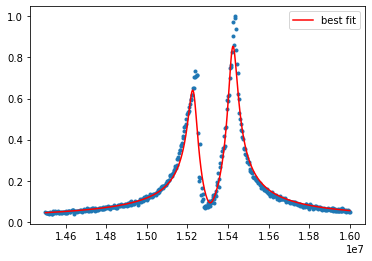

In [7]:
#Fit curve to large resonator
model1 = Model(curve1)

params = model1.make_params(k_2 = 0.0063, k_12 = 6*10**-5, m_2 = 2.7*10**-17)
result = model1.fit(y1, params, w = x1)

#Plot Result

print(result.fit_report())

plt.plot(x1, y1, '.')
#plt.plot(x1, result.init_fit, 'k--', label='initial fit')
plt.plot(x1, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

[[Model]]
    Model(theta1)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 500
    # variables        = 3
    chi-square         = 22.5074118
    reduced chi-square = 0.04528654
    Akaike info crit   = -1544.38172
    Bayesian info crit = -1531.73789
[[Variables]]
    k_2:   0.01109289 +/- 6.7855e-04 (6.12%) (init = 0.0063)
    k_12:  9.3240e-05 +/- 1.7765e-06 (1.91%) (init = 6e-05)
    m_2:   4.7859e-17 +/- 2.9132e-18 (6.09%) (init = 2.7e-17)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_2, m_2)  =  1.000
    C(k_12, m_2) =  0.875
    C(k_2, k_12) =  0.874


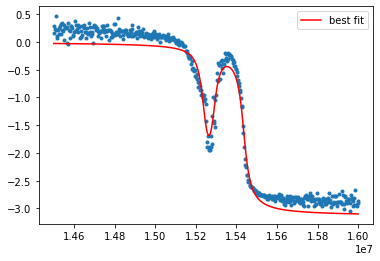

In [8]:
#Fit curve to large resonator

model_t1 = Model(theta1)

params = model_t1.make_params(k_2 = 0.0063, k_12 = 6*10**-5, m_2 = 2.7*10**-17)
result = model_t1.fit(th1, params, w = x1)

#Plot Result

print(result.fit_report())

plt.plot(x1, th1, '.')
#plt.plot(x1, result.init_fit, 'k--', label='initial fit')
plt.plot(x1, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

[[Model]]
    Model(curve2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 500
    # variables        = 3
    chi-square         = 2.17113343
    reduced chi-square = 0.00436848
    Akaike info crit   = -2713.67938
    Bayesian info crit = -2701.03555
[[Variables]]
    k_2:   0.00214069 +/- 3.0842e-05 (1.44%) (init = 0.0063)
    k_12:  4.3857e-05 +/- 3.7018e-07 (0.84%) (init = 6e-05)
    m_2:   9.3788e-18 +/- 1.3367e-19 (1.43%) (init = 2.7e-17)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_2, m_2)  =  1.000
    C(k_12, m_2) =  0.751
    C(k_2, k_12) =  0.746


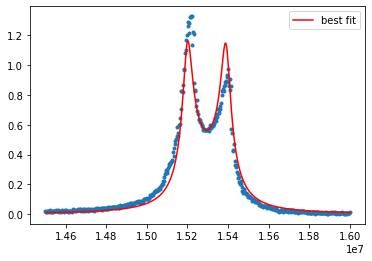

In [9]:
#Fit curve to small resonator

model2 = Model(curve2)

params = model2.make_params(k_2 = 0.0063, k_12 = 6*10**-5, m_2 = 2.7*10**-17)
result = model2.fit(y2, params, w = x2)

#Plot Result

print(result.fit_report())

plt.plot(x2, y2, '.')
#plt.plot(x2, result.init_fit, 'k--', label='initial fit')
plt.plot(x2, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

[[Model]]
    Model(theta2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 500
    # variables        = 3
    chi-square         = 144.621545
    reduced chi-square = 0.29098902
    Akaike info crit   = -614.243901
    Bayesian info crit = -601.600077
[[Variables]]
    k_2:   0.01037770 +/- 2.55383392 (24608.87%) (init = 0.0063)
    k_12:  8.1917e-05 +/- 0.00520558 (6354.73%) (init = 6e-05)
    m_2:   4.4888e-17 +/- 1.1020e-14 (24549.48%) (init = 2.7e-17)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_2, m_2)  =  1.000
    C(k_12, m_2) =  1.000
    C(k_2, k_12) =  1.000


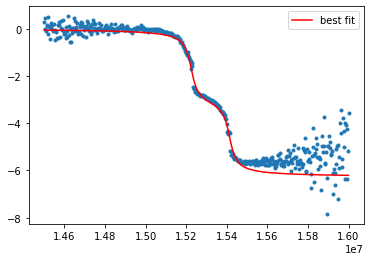

In [10]:
#Fit curve to small resonator

model_t2 = Model(theta2)

params = model_t2.make_params(k_2 = 0.0063, k_12 = 6*10**-5, m_2 = 2.7*10**-17)
result = model_t2.fit(th2, params, w = x2)

#Plot Result

print(result.fit_report())

plt.plot(x1, th2, '.')
#plt.plot(x1, result.init_fit, 'k--', label='initial fit')
plt.plot(x1, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

[[Model]]
    Model(diff)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 500
    # variables        = 3
    chi-square         = 128.805987
    reduced chi-square = 0.25916698
    Akaike info crit   = -672.150400
    Bayesian info crit = -659.506576
[[Variables]]
    k_2:   108.210091 +/- 269998.303 (249513.05%) (init = 0.0063)
    k_12:  0.74677202 +/- 533911.782 (71495954.15%) (init = 6e-05)
    m_2:   4.6661e-13 +/- 1.1341e-09 (243059.37%) (init = 2.7e-17)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_2, k_12) = -0.998
    C(k_12, m_2) =  0.998
    C(k_2, m_2)  = -0.993


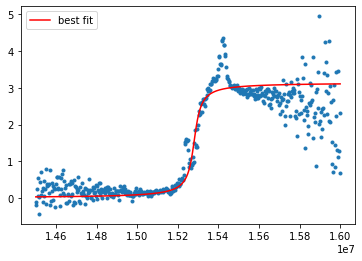

In [11]:
#Fit curve to phase difference

d2 = sp.lambdify((wd, k2, k12, m2),wrap1-wrap2) 

def diff(w, k_2, k_12, m_2):
     return d2(w, k_2, k_12, m_2)
    
y_diff = df1.wrap.values-df2.wrap.values

model = Model(diff)

params = model.make_params(k_2 = 0.0063, k_12 = 6*10**-5, m_2 = 2.7*10**-17)
result = model.fit(y_diff, params, w = x1)

#Plot Result

print(result.fit_report())

plt.plot(x1, y_diff, '.')
#plt.plot(x1, result.init_fit, 'k--', label='initial fit')
plt.plot(x1, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

In [12]:
def residual(params, w1, w2, data_amp1, data_phase1, data_amp2, data_phase2):
    k_2 = params['k2']
    k_12 = params['k12']
    m_2 = params['m2']
    
    model1 = curve1(w1, k_2, k_12, m_2)
    model2 = theta1(w1, k_2, k_12, m_2)
    model3 = curve2(w2, k_2, k_12, m_2)
    model4 = theta2(w2, k_2, k_12, m_2)
    
    resid1 = data_amp1 - model1
    resid2 = data_phase1 - model2
    resid3 = data_amp2 - model3
    resid4 = data_phase2 - model4

    return np.concatenate((resid1, resid2, resid3, resid4))

params2 = lmfit.Parameters()
params2.add('k2', value = 0.0063)
params2.add('k12', value = 6*10**-5)
params2.add('m2', value = 2.7*10**-17)

out = lmfit.minimize(residual, params2, args = (x1, x2, y1, th1, y2, th2))

k_2 = out.params['k2'].value
k_12 = out.params['k12'].value
m_2 = out.params['m2'].value

print(lmfit.fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 2000
    # variables        = 3
    chi-square         = 195.463259
    reduced chi-square = 0.09787845
    Akaike info crit   = -4645.06007
    Bayesian info crit = -4628.25736
[[Variables]]
    k2:   0.00441982 +/- 2.7102e-04 (6.13%) (init = 0.0063)
    k12:  6.5541e-05 +/- 1.6511e-06 (2.52%) (init = 6e-05)
    m2:   1.9183e-17 +/- 1.1681e-18 (6.09%) (init = 2.7e-17)
[[Correlations]] (unreported correlations are < 0.100)
    C(k2, m2)  =  1.000
    C(k12, m2) =  0.928
    C(k2, k12) =  0.927


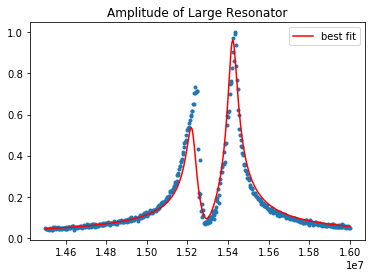

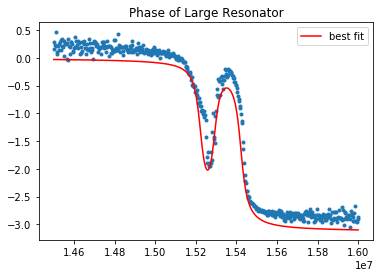

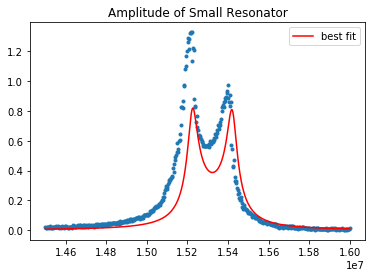

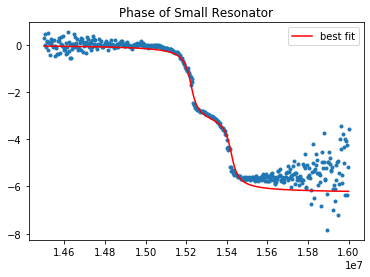

In [13]:
#Plot Result
plt.plot(x1, y1, '.')
plt.plot(x1, curve1(x1, k_2, k_12, m_2), 'r-', label='best fit')
plt.title('Amplitude of Large Resonator')
plt.legend(loc='best')
plt.show()

plt.plot(x1, th1, '.')
plt.plot(x1, theta1(x1, k_2, k_12, m_2), 'r-', label='best fit')
plt.legend(loc='best')
plt.title('Phase of Large Resonator')
plt.show()

plt.plot(x2, y2, '.')
plt.plot(x1, curve2(x2, k_2, k_12, m_2), 'r-', label='best fit')
plt.legend(loc='best')
plt.title('Amplitude of Small Resonator')
plt.show()

plt.plot(x2, th2, '.')
plt.plot(x1, theta2(x2, k_2, k_12, m_2), 'r-', label='best fit')
plt.legend(loc='best')
plt.title('Phase of Small Resonator')
plt.show()

File not overwritten: 
\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports\CoupledResonanceCurvesAndFits.pdf


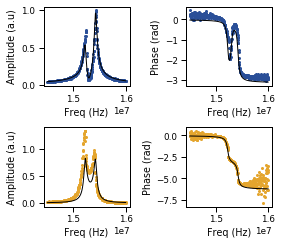

In [14]:
#Plots for paper

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (4,3.5))

ax1.plot(x1, y1, '.', markersize = 4, color = m1_col)
ax1.plot(x1, curve1(x1, k_2, k_12, m_2), '-', color='black', linewidth = 1)
ax1.set_xlabel('Freq (Hz)')
ax1.set_ylabel('Amplitude (a.u)')

ax2.plot(x1, th1, '.', markersize = 4, color = m1_col)
ax2.plot(x1, theta1(x1, k_2, k_12, m_2), '-', color='black', linewidth = 1)
ax2.set_xlabel('Freq (Hz)')
ax2.set_ylabel('Phase (rad)')

ax3.plot(x2, y2, '.', markersize = 4, color = m2_col)
ax3.plot(x1, curve2(x2, k_2, k_12, m_2), '-', color='black', linewidth = 1)
ax3.set_xlabel('Freq (Hz)')
ax3.set_ylabel('Amplitude (a.u)')

ax4.plot(x2, th2, '.', markersize = 4, color = m2_col)
ax4.plot(x1, theta2(x2, k_2, k_12, m_2), '-', color='black', linewidth = 1)
ax4.set_xlabel('Freq (Hz)')
ax4.set_ylabel('Phase (rad)')

plt.tight_layout()

if Vivaflag:
    savefolder = r"\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports"
else:    
    savefolder = '/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports'

savefile = 'CoupledResonanceCurvesAndFits_Hz.pdf'
if saving: 
    fig.savefig(os.path.join(savefolder, savefile), bbox_inches= 'tight', pad_inches=0.05)
    print('File saved: ')
else:
    print('File not overwritten: ')
print(os.path.join(savefolder, savefile))

In [15]:
#lambdify curves

c1 = sp.lambdify((wd, k2, k12, m2),amp1)
t1 = sp.lambdify((wd, k2, k12, m2),wrap1)
c2 = sp.lambdify((wd, k2, k12, m2),amp2)
t2 = sp.lambdify((wd, k2, k12, m2),wrap2)

#define functions

def curve1(w, k_2, k_12, m_2):
     return c1(w, k_2, k_12, m_2)
    
def theta1(w, k_2, k_12, m_2, d):
     return t1(w, k_2, k_12, m_2) - 2*np.pi + d
    
def curve2(w, k_2, k_12, m_2):
     return c2(w, k_2, k_12, m_2)
    
def theta2(w, k_2, k_12, m_2, d):
     return t2(w, k_2, k_12, m_2) - 2*np.pi + d
    
#Definte data

x1 = df1.F.values
y1 = df1.Rnorm.values
th1 = df1.wrap.values

x2 = df2.F.values
y2 = df2.Rnorm.values
th2 = df2.wrap.values

In [16]:
def residual_large(params, w1, data_amp1, data_phase1):
    k_2 = params['k2']
    k_12 = params['k12']
    m_2 = params['m2']
    d = params['d']
    
    model1 = curve1(w1, k_2, k_12, m_2)
    model2 = theta1(w1, k_2, k_12, m_2, d)
    
    resid1 = data_amp1 - model1
    resid2 = data_phase1 - model2
   
    return np.concatenate((resid1, resid2))

params2 = lmfit.Parameters()
params2.add('k2', value = 0.0063)
params2.add('k12', value = 6*10**-5)
params2.add('m2', value = 2.7*10**-17)
params2.add('d', value = 0.2)

out = lmfit.minimize(residual_large, params2, args = (x1, y1, th1))

k_2 = out.params['k2'].value
k_12 = out.params['k12'].value
m_2 = out.params['m2'].value
d = out.params['d'].value

print('k2 =', k_2, )
print('k12 =', k_12)
print('m2 = ', m_2)
print('d = ', d)

k2 = 0.0057520211085559745
k12 = 7.311979417520973e-05
m2 =  2.490075348070683e-17
d =  0.20916356106004996


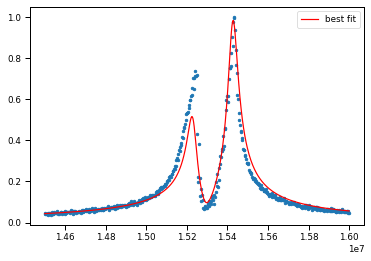

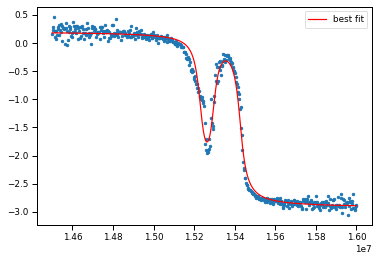

In [17]:
#Plot Result
plt.plot(x1, y1, '.')
plt.plot(x1, curve1(x1, k_2, k_12, m_2), 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

plt.plot(x1, th1, '.')
plt.plot(x1, theta1(x1, k_2, k_12, m_2, d), 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

In [18]:
def residual_small(params, w2, data_amp2, data_phase2):
    k_2 = params['k2']
    k_12 = params['k12']
    m_2 = params['m2']
    d = params['d']
    
    model1 = curve2(w2, k_2, k_12, m_2)
    model2 = theta2(w2, k_2, k_12, m_2, d)
    
    resid1 = data_amp2 - model1
    resid2 = data_phase2 - model2
   
    return np.concatenate((resid1, resid2))

params2 = lmfit.Parameters()
params2.add('k2', value = 0.0063)
params2.add('k12', value = 6*10**-5)
params2.add('m2', value = 2.7*10**-17)
params2.add('d', value = 0.2)

out = lmfit.minimize(residual_small, params2, args = (x2, y2, th2))

k_2 = out.params['k2'].value
k_12 = out.params['k12'].value
m_2 = out.params['m2'].value
d = out.params['d'].value

print('k2 =', k_2, )
print('k12 =', k_12)
print('m2 = ', m_2)
print('d = ', d)

k2 = 0.0022484489484665493
k12 = 4.565978287082535e-05
m2 =  9.832613284102698e-18
d =  0.3359706090736974


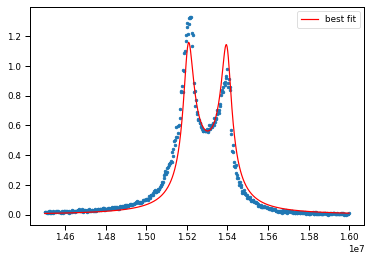

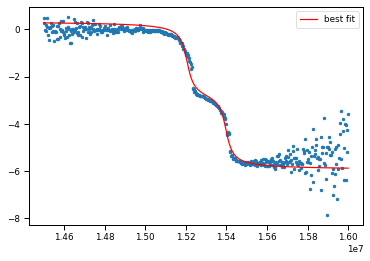

In [19]:
plt.plot(x1, y2, '.')
plt.plot(x1, curve2(x1, k_2, k_12, m_2), 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

plt.plot(x1, th2, '.')
plt.plot(x1, theta2(x1, k_2, k_12, m_2, d), 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

In [20]:
def residual_phase(params, w1, w2, data_phase1, data_phase2):
    k_2 = params['k2']
    k_12 = params['k12']
    m_2 = params['m2']
    d1 = params['d1']
    d2 = params['d2']
    
    model1 = theta1(w1, k_2, k_12, m_2, d1)
    model2 = theta2(w2, k_2, k_12, m_2, d2)
    
    resid1 = data_phase1 - model1
    resid2 = data_phase2 - model2
   
    return np.concatenate((resid1, resid2))

params2 = lmfit.Parameters()
params2.add('k2', value = 0.0063)
params2.add('k12', value = 6*10**-5)
params2.add('m2', value = 2.7*10**-17)
params2.add('d1', value = 0.2)
params2.add('d2', value = 0.2)

out = lmfit.minimize(residual_phase, params2, args = (x1, x2, th1, th2))

k_2 = out.params['k2'].value
k_12 = out.params['k12'].value
m_2 = out.params['m2'].value
d1 = out.params['d1'].value
d2 = out.params['d2'].value

print('k2 =', k_2, )
print('k12 =', k_12)
print('m2 = ', m_2)
print('d1 = ', d1)
print('d2 = ', d2)

k2 = 0.0033432555272524898
k12 = 5.688415277257732e-05
m2 =  1.4545788906965704e-17
d1 =  0.24923910753179626
d2 =  0.27901144099333836


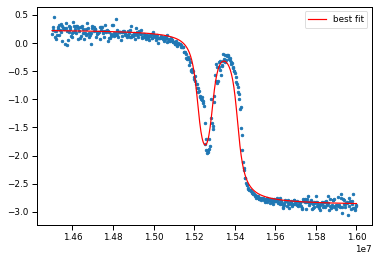

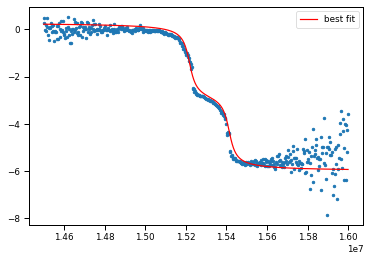

In [21]:
plt.plot(x1, th1, '.')
plt.plot(x1, theta1(x1, k_2, k_12, m_2, d1), 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

plt.plot(x2, th2, '.')
plt.plot(x2, theta2(x2, k_2, k_12, m_2, d2), 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

**New set of fitting parameters with m1 and m2 as fixed parameters**

In [22]:
#Define all variables

#individual springs that correspond to individual masses
k1 = sp.symbols('k_1')
k2 = sp.symbols('k_2')

#springs that connect two masses
k12 = sp.symbols('k_12')

#damping coefficients and forc
g1, g2 = (5*10**4,5*10**4)
 
#masses
m1 = 2.7*10**-17
m2 = 0.68*10**-17

#Driving force amplitude
F = (3*10**-5)

#driving frequency (leave as variable)
wd = sp.symbols('\omega_d')

In [23]:
#Solve for driving amplitudes and phase

#Matrix for complex equations of motion
driven = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), -k12/m1], [-k12/m2, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

#Matrices for Cramer's Rule
driven_m1 = sp.Matrix([[F/m1, -k12/m1], [0, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

driven_m2 = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), F/m1], [-k12/m2, 0]])

#Apply Cramer's Rule
Cr1, Cr2 = (driven_m1.det()/driven.det(),driven_m2.det()/driven.det())

#Solve for phases for each mass
delta1 = sp.arg(Cr1)
delta2 = sp.arg(Cr2)

#Wrap phases for plots

wrap1 = (delta1)%(2*np.pi)
wrap2 = (delta2)%(2*np.pi)

#Solve for amplitude coefficients
amp1 = sp.re(Cr1)/sp.cos(delta1)
amp2 = sp.re(Cr2)/sp.cos(delta2)

In [24]:
#lambdify curves

c1 = sp.lambdify((wd, k1, k2, k12),amp1)
t1 = sp.lambdify((wd, k1, k2, k12),wrap1)
c2 = sp.lambdify((wd, k1, k2, k12),amp2)
t2 = sp.lambdify((wd, k1, k2, k12),wrap2)

#define functions

def curve1(w, k_1, k_2, k_12):
     return c1(w, k_1, k_2, k_12)
    
def theta1(w, k_1, k_2, k_12, d):
     return t1(w, k_1, k_2, k_12) - 2*np.pi + d
    
def curve2(w, k_1, k_2, k_12):
     return c2(w, k_1, k_2, k_12)
    
def theta2(w, k_1, k_2, k_12, d):
     return t2(w, k_1, k_2, k_12) - 2*np.pi + d
    
#Definte data

x1 = df1.F.values
y1 = df1.Rnorm.values
th1 = df1.wrap.values

x2 = df2.F.values
y2 = df2.Rnorm.values
th2 = df2.wrap.values

In [25]:
def residual(params, w1, w2, data_amp1, data_phase1, data_amp2, data_phase2):
    k_1 = params['k1']
    k_2 = params['k2']
    k_12 = params['k12']
    d = params['d']
    
    model1 = curve1(w1, k_1, k_2, k_12)
    model2 = theta1(w1, k_1, k_2, k_12, d)
    model3 = curve2(w2, k_1, k_2, k_12)
    model4 = theta2(w2, k_1, k_2, k_12, d)
    
    resid1 = data_amp1 - model1
    resid2 = data_phase1 - model2
    resid3 = data_amp2 - model3
    resid4 = data_phase2 - model4

    return np.concatenate((resid1, resid2, resid3, resid4))

params2 = lmfit.Parameters()
params2.add('k1', value = 0.0063, min = 0)
params2.add('k2', value = 0.001, min = 0)
params2.add('k12', value = 6*10**-5, min = 0)
params2.add('d', value = 0.2, min = 0)

out = lmfit.minimize(residual, params2, args = (x1, x2, y1, th1, y2, th2))

k_1 = out.params['k1'].value
k_2 = out.params['k2'].value
k_12 = out.params['k12'].value
d = out.params['d'].value

print(lmfit.fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 85
    # data points      = 2000
    # variables        = 4
    chi-square         = 131.854084
    reduced chi-square = 0.06605916
    Akaike info crit   = -5430.41315
    Bayesian info crit = -5408.00954
[[Variables]]
    k1:   0.00631442 +/- 2.0129e-06 (0.03%) (init = 0.0063)
    k2:   0.00155002 +/- 4.1006e-07 (0.03%) (init = 0.001)
    k12:  3.9275e-05 +/- 3.8108e-07 (0.97%) (init = 6e-05)
    d:    0.27314081 +/- 0.00887611 (3.25%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k12) = -0.590
    C(k2, k12) = -0.588
    C(k1, d)   = -0.365
    C(k12, d)  =  0.150


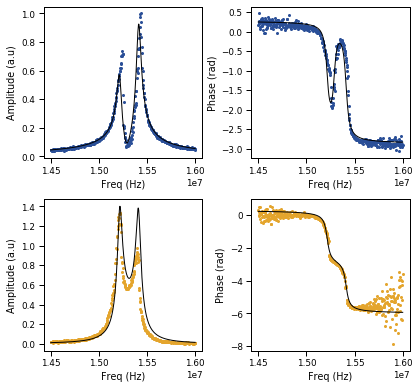

In [26]:
#Plots for paper

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (6,5.5))

ax1.plot(x1, y1, '.', markersize = 4, color = m1_col)
ax1.plot(x1, curve1(x1, k_1, k_2, k_12), '-', color='black', linewidth = 1)
ax1.set_xlabel('Freq (Hz)')
ax1.set_ylabel('Amplitude (a.u)')

ax2.plot(x1, th1, '.', markersize = 4, color = m1_col)
ax2.plot(x1, theta1(x1, k_1, k_2, k_12, d), '-', color='black', linewidth = 1)
ax2.set_xlabel('Freq (Hz)')
ax2.set_ylabel('Phase (rad)')

ax3.plot(x2, y2, '.', markersize = 4, color = m2_col)
ax3.plot(x1, curve2(x2, k_1, k_2, k_12), '-', color='black', linewidth = 1)
ax3.set_xlabel('Freq (Hz)')
ax3.set_ylabel('Amplitude (a.u)')

ax4.plot(x2, th2, '.', markersize = 4, color = m2_col)
ax4.plot(x1, theta2(x2, k_1, k_2, k_12, d), '-', color='black', linewidth = 1)
ax4.set_xlabel('Freq (Hz)')
ax4.set_ylabel('Phase (rad)')

plt.tight_layout()

if saving:
    fig.savefig(os.path.join(savefolder, 'CoupledResonanceCurvesAndFits_Hz,large.pdf'), bbox_inches= 'tight', pad_inches=0.05)

**Fit that includes factor of Pi**

In [27]:
#Define all variables

#individual springs that correspond to individual masses
k1 = sp.symbols('k_1')
k2 = sp.symbols('k_2')

#springs that connect two masses
k12 = sp.symbols('k_12')

#damping coefficients and forc
g1, g2 = (3*10**5,3*10**5)
 
#masses
m1 = 2.7*10**-17
m2 = 0.68*10**-17

#Driving force amplitude
F = (1.1*10**-3)

#driving frequency (leave as variable)
wd = sp.symbols('\omega_d')

In [28]:
#Solve for driving amplitudes and phase

#Matrix for complex equations of motion
driven = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), -k12/m1], [-k12/m2, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

#Matrices for Cramer's Rule
driven_m1 = sp.Matrix([[F/m1, -k12/m1], [0, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

driven_m2 = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), F/m1], [-k12/m2, 0]])

#Apply Cramer's Rule
Cr1, Cr2 = (driven_m1.det()/driven.det(),driven_m2.det()/driven.det())

#Solve for phases for each mass
delta1 = sp.arg(Cr1)
delta2 = sp.arg(Cr2)

#Wrap phases for plots

wrap1 = (delta1)%(2*np.pi)
wrap2 = (delta2)%(2*np.pi)

#Solve for amplitude coefficients
amp1 = sp.re(Cr1)/sp.cos(delta1)
amp2 = sp.re(Cr2)/sp.cos(delta2)

In [29]:
#lambdify curves

c1 = sp.lambdify((wd, k1, k2, k12),amp1)
t1 = sp.lambdify((wd, k1, k2, k12),wrap1)
c2 = sp.lambdify((wd, k1, k2, k12),amp2)
t2 = sp.lambdify((wd, k1, k2, k12),wrap2)

#define functions

def curve1(w, k_1, k_2, k_12):
     return c1(w, k_1, k_2, k_12)
    
def theta1(w, k_1, k_2, k_12, d):
     return t1(w, k_1, k_2, k_12) - 2*np.pi + d
    
def curve2(w, k_1, k_2, k_12):
     return c2(w, k_1, k_2, k_12)
    
def theta2(w, k_1, k_2, k_12, d):
     return t2(w, k_1, k_2, k_12) - 2*np.pi + d
    
#Definte data

x1 = df1.F.values * 2 * np.pi
y1 = df1.Rnorm.values
th1 = df1.wrap.values

x2 = df2.F.values * 2 * np.pi
y2 = df2.Rnorm.values
th2 = df2.wrap.values

In [30]:
def residual(params, w1, w2, data_amp1, data_phase1, data_amp2, data_phase2):
    k_1 = params['k1']
    k_2 = params['k2']
    k_12 = params['k12']
    d = params['d']
    
    model1 = curve1(w1, k_1, k_2, k_12)
    model2 = theta1(w1, k_1, k_2, k_12, d)
    model3 = curve2(w2, k_1, k_2, k_12)
    model4 = theta2(w2, k_1, k_2, k_12, d)
    
    resid1 = data_amp1 - model1
    resid2 = data_phase1 - model2
    resid3 = data_amp2 - model3
    resid4 = data_phase2 - model4

    return np.concatenate((resid1, resid2, resid3, resid4))

params2 = lmfit.Parameters()
params2.add('k1', value = 0.24, min = 0)
params2.add('k2', value = 0.06, min = 0)
params2.add('k12', value = 2.5*10**-4, min = 0)
params2.add('d', value = 0.2, min = 0)

out = lmfit.minimize(residual, params2, args = (x1, x2, y1, th1, y2, th2))

k_1 = out.params['k1'].value
k_2 = out.params['k2'].value
k_12 = out.params['k12'].value
d = out.params['d'].value

print(lmfit.fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 76
    # data points      = 2000
    # variables        = 4
    chi-square         = 131.907468
    reduced chi-square = 0.06608591
    Akaike info crit   = -5429.60357
    Bayesian info crit = -5407.19996
[[Variables]]
    k1:   0.24927288 +/- 7.8609e-05 (0.03%) (init = 0.24)
    k2:   0.06119609 +/- 1.5866e-05 (0.03%) (init = 0.06)
    k12:  0.00155213 +/- 1.4771e-05 (0.95%) (init = 0.00025)
    d:    0.27288425 +/- 0.00886214 (3.25%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k12) = -0.589
    C(k2, k12) = -0.587
    C(k1, d)   = -0.362
    C(k12, d)  =  0.149


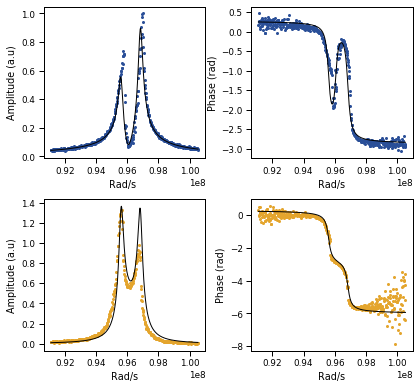

In [31]:
#Plots for paper

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (6,5.5))

ax1.plot(x1, y1, '.', markersize = 4, color = m1_col)
ax1.plot(x1, curve1(x1, k_1, k_2, k_12), '-', color='black', linewidth = 1)
ax1.set_xlabel('Rad/s ')
ax1.set_ylabel('Amplitude (a.u)')

ax2.plot(x1, th1, '.', markersize = 4, color = m1_col)
ax2.plot(x1, theta1(x1, k_1, k_2, k_12, d), '-', color='black', linewidth = 1)
ax2.set_xlabel('Rad/s')
ax2.set_ylabel('Phase (rad)')

ax3.plot(x2, y2, '.', markersize = 4, color = m2_col)
ax3.plot(x1, curve2(x2, k_1, k_2, k_12), '-', color='black', linewidth = 1)
ax3.set_xlabel('Rad/s')
ax3.set_ylabel('Amplitude (a.u)')

ax4.plot(x2, th2, '.', markersize = 4, color = m2_col)
ax4.plot(x1, theta2(x2, k_1, k_2, k_12, d), '-', color='black', linewidth = 1)
ax4.set_xlabel('Rad/s')
ax4.set_ylabel('Phase (rad)')

plt.tight_layout()

if saving:
    fig.savefig(os.path.join(savefolder, 'CoupledResonanceCurvesAndFits_radians.pdf'), bbox_inches= 'tight', pad_inches=0.05)

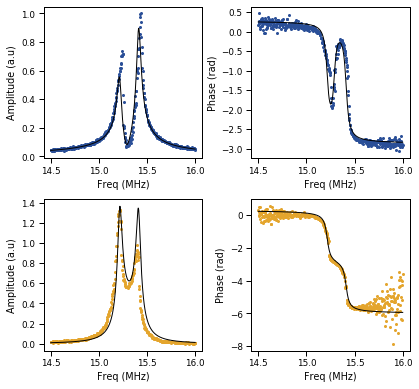

In [32]:
#Plots for paper

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (6,5.5))

ax1.plot(x1/(2*np.pi*10**6), y1, '.', markersize = 4, color = m1_col)
ax1.plot(x1/(2*np.pi*10**6), curve1(x1, k_1, k_2, k_12), '-', color='black', linewidth = 1)
ax1.set_xlabel('Freq (MHz)')
ax1.set_ylabel('Amplitude (a.u)')

ax2.plot(x1/(2*np.pi*10**6), th1, '.', markersize = 4, color = m1_col)
ax2.plot(x1/(2*np.pi*10**6), theta1(x1, k_1, k_2, k_12, d), '-', color='black', linewidth = 1)
ax2.set_xlabel('Freq (MHz)')
ax2.set_ylabel('Phase (rad)')

ax3.plot(x2/(2*np.pi*10**6), y2, '.', markersize = 4, color = m2_col)
ax3.plot(x1/(2*np.pi*10**6), curve2(x2, k_1, k_2, k_12), '-', color='black', linewidth = 1)
ax3.set_xlabel('Freq (MHz)')
ax3.set_ylabel('Amplitude (a.u)')

ax4.plot(x2/(2*np.pi*10**6), th2, '.', markersize = 4, color = m2_col)
ax4.plot(x1/(2*np.pi*10**6), theta2(x2, k_1, k_2, k_12, d), '-', color='black', linewidth = 1)
ax4.set_xlabel('Freq (MHz)')
ax4.set_ylabel('Phase (rad)')

plt.tight_layout()

if saving:
    fig.savefig(os.path.join(savefolder, 'CoupledResonanceCurvesAndFits_MHz.pdf'), bbox_inches= 'tight', pad_inches=0.05)

**Fit with mass that includes contamination (7*pristine graphene)**

In [33]:
#Define all variables

#individual springs that correspond to individual masses
k1 = sp.symbols('k_1')
k2 = sp.symbols('k_2')

#springs that connect two masses
k12 = sp.symbols('k_12')

#damping coefficients and forc
g1, g2 = (3*10**5,3*10**5)
 
#masses
m1 = 7*(2.7*10**-17)
m2 = 7*(0.68*10**-17)

#Driving force amplitude
F = (7.65*10**-3)

#driving frequency (leave as variable)
wd = sp.symbols('\omega_d')

In [34]:
#Solve for driving amplitudes and phase

#Matrix for complex equations of motion
driven = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), -k12/m1], [-k12/m2, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

#Matrices for Cramer's Rule
driven_m1 = sp.Matrix([[F/m1, -k12/m1], [0, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

driven_m2 = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), F/m1], [-k12/m2, 0]])

#Apply Cramer's Rule
Cr1, Cr2 = (driven_m1.det()/driven.det(),driven_m2.det()/driven.det())

#Solve for phases for each mass
delta1 = sp.arg(Cr1)
delta2 = sp.arg(Cr2)

#Wrap phases for plots

wrap1 = (delta1)%(2*np.pi)
wrap2 = (delta2)%(2*np.pi)

#Solve for amplitude coefficients
amp1 = sp.re(Cr1)/sp.cos(delta1)
amp2 = sp.re(Cr2)/sp.cos(delta2)

In [35]:
#lambdify curves

c1 = sp.lambdify((wd, k1, k2, k12),amp1)
t1 = sp.lambdify((wd, k1, k2, k12),wrap1)
c2 = sp.lambdify((wd, k1, k2, k12),amp2)
t2 = sp.lambdify((wd, k1, k2, k12),wrap2)

#define functions

def curve1(w, k_1, k_2, k_12):
     return c1(w, k_1, k_2, k_12)
    
def theta1(w, k_1, k_2, k_12, d):
     return t1(w, k_1, k_2, k_12) - 2*np.pi + d
    
def curve2(w, k_1, k_2, k_12):
     return c2(w, k_1, k_2, k_12)
    
def theta2(w, k_1, k_2, k_12, d):
     return t2(w, k_1, k_2, k_12) - 2*np.pi + d
    
#Definte data

x1 = df1.F.values * 2 * np.pi
y1 = df1.Rnorm.values
th1 = df1.wrap.values

x2 = df2.F.values * 2 * np.pi
y2 = df2.Rnorm.values
th2 = df2.wrap.values

In [36]:
def residual(params, w1, w2, data_amp1, data_phase1, data_amp2, data_phase2):
    k_1 = params['k1']
    k_2 = params['k2']
    k_12 = params['k12']
    d = params['d']
    
    model1 = curve1(w1, k_1, k_2, k_12)
    model2 = theta1(w1, k_1, k_2, k_12, d)
    model3 = curve2(w2, k_1, k_2, k_12)
    model4 = theta2(w2, k_1, k_2, k_12, d)
    
    resid1 = data_amp1 - model1
    resid2 = data_phase1 - model2
    resid3 = data_amp2 - model3
    resid4 = data_phase2 - model4

    return np.concatenate((resid1, resid2, resid3, resid4))

params2 = lmfit.Parameters()
params2.add('k1', value = 1.7, min = 0)
params2.add('k2', value = 0.44, min = 0)
params2.add('k12', value = 0.01, min = 0)
params2.add('d', value = 0.2, min = 0)

out = lmfit.minimize(residual, params2, args = (x1, x2, y1, th1, y2, th2))

k_1 = out.params['k1'].value
k_2 = out.params['k2'].value
k_12 = out.params['k12'].value
d = out.params['d'].value

print(lmfit.fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 2000
    # variables        = 4
    chi-square         = 131.751219
    reduced chi-square = 0.06600762
    Akaike info crit   = -5431.97404
    Bayesian info crit = -5409.57043
[[Variables]]
    k1:   1.74489371 +/- 5.5055e-04 (0.03%) (init = 1.7)
    k2:   0.42837416 +/- 1.1117e-04 (0.03%) (init = 0.44)
    k12:  0.01086701 +/- 1.0340e-04 (0.95%) (init = 0.01)
    d:    0.27294787 +/- 0.00885899 (3.25%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(k2, k12) = -0.588
    C(k1, k12) = -0.588
    C(k1, d)   = -0.363
    C(k12, d)  =  0.148


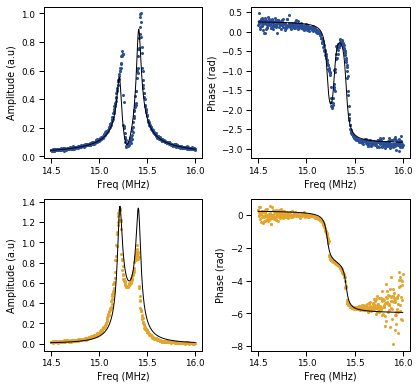

In [37]:
#Plots for paper

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (6,5.5))

ax1.plot(x1/(2*np.pi*10**6), y1, '.', markersize = 4, color = m1_col)
ax1.plot(x1/(2*np.pi*10**6), curve1(x1, k_1, k_2, k_12), '-', color='black', linewidth = 1)
ax1.set_xlabel('Freq (MHz)')
ax1.set_ylabel('Amplitude (a.u)')

ax2.plot(x1/(2*np.pi*10**6), th1, '.', markersize = 4, color = m1_col)
ax2.plot(x1/(2*np.pi*10**6), theta1(x1, k_1, k_2, k_12, d), '-', color='black', linewidth = 1)
ax2.set_xlabel('Freq (MHz)')
ax2.set_ylabel('Phase (rad)')

ax3.plot(x2/(2*np.pi*10**6), y2, '.', markersize = 4, color = m2_col)
ax3.plot(x1/(2*np.pi*10**6), curve2(x2, k_1, k_2, k_12), '-', color='black', linewidth = 1)
ax3.set_xlabel('Freq (MHz)')
ax3.set_ylabel('Amplitude (a.u)')

ax4.plot(x2/(2*np.pi*10**6), th2, '.', markersize = 4, color = m2_col)
ax4.plot(x1/(2*np.pi*10**6), theta2(x2, k_1, k_2, k_12, d), '-', color='black', linewidth = 1)
ax4.set_xlabel('Freq (MHz)')
ax4.set_ylabel('Phase (rad)')

plt.tight_layout()

fig.savefig(os.path.join(savefolder, 'CoupledResonanceCurvesAndFits_MHz2.pdf'), bbox_inches= 'tight', pad_inches=0.05)

**Fit to R1 data only**

In [38]:
#Define all variables

#individual springs that correspond to individual masses
k1 = 1.75
k2 = sp.symbols('k_2')

#springs that connect two masses
k12 = sp.symbols('k_12')

#damping coefficients and forc
g1, g2 = (3*10**5,3*10**5)
 
#masses
m1 = 7*(2.7*10**-17)
m2 = sp.symbols('m_2')

#Driving force amplitude
F = 9*10**-3

#driving frequency (leave as variable)
wd = sp.symbols('\omega_d')

In [39]:
#Solve for driving amplitudes and phase

#Matrix for complex equations of motion
driven = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), -k12/m1], [-k12/m2, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

#Matrices for Cramer's Rule
driven_m1 = sp.Matrix([[F/m1, -k12/m1], [0, -wd**2 + 
  1j*wd*g2 + (k2/m2) + (k12/m2)]])

driven_m2 = sp.Matrix([[-wd**2 + 1j*wd*g1 + (k1/m1) + (k12/m1), F/m1], [-k12/m2, 0]])

#Apply Cramer's Rule
Cr1, Cr2 = (driven_m1.det()/driven.det(),driven_m2.det()/driven.det())

#Solve for phases for each mass
delta1 = sp.arg(Cr1)
delta2 = sp.arg(Cr2)

#Wrap phases for plots

wrap1 = (delta1)%(2*np.pi)
wrap2 = (delta2)%(2*np.pi)

#Solve for amplitude coefficients
amp1 = sp.re(Cr1)/sp.cos(delta1)
amp2 = sp.re(Cr2)/sp.cos(delta2)

In [40]:
#lambdify curves

c1 = sp.lambdify((wd, m2, k2, k12),amp1)
t1 = sp.lambdify((wd, m2, k2, k12),wrap1)
c2 = sp.lambdify((wd, m2, k2, k12),amp2)
t2 = sp.lambdify((wd, m2, k2, k12),wrap2)

#define functions

def curve1(w, m_2, k_2, k_12):
     return c1(w, m_2, k_2, k_12)
    
def theta1(w, m_2, k_2, k_12, d):
     return t1(w, m_2, k_2, k_12) - 2*np.pi + d
    
def curve2(w, m_2, k_2, k_12):
     return c2(w, m_2, k_2, k_12)
    
def theta2(w, m_2, k_2, k_12, d):
     return t2(w, m_2, k_2, k_12) - 2*np.pi + d
    
#Definte data

x1 = df1.F.values * 2 * np.pi
y1 = df1.Rnorm.values
th1 = df1.wrap.values

x2 = df2.F.values * 2 * np.pi
y2 = df2.Rnorm.values
th2 = df2.wrap.values

In [41]:
def residual2(params, w1, data_amp1, data_phase1):
    m_2 = params['m2']
    k_2 = params['k2']
    k_12 = params['k12']
    d = params['d']
    
    model1 = curve1(w1, m_2, k_2, k_12)
    model2 = theta1(w1, m_2, k_2, k_12, d)
    #model3 = curve2(w2, m_2, k_2, k_12)
    #model4 = theta2(w2, m_2, k_2, k_12, d)
    
    resid1 = data_amp1 - model1
    resid2 = data_phase1 - model2

    return np.concatenate((resid1, resid2))

params2 = lmfit.Parameters()
params2.add('m2', value = 7*0.68*10**-17)
params2.add('k2', value = 0.43, min = 0)
params2.add('k12', value = 0.01, min = 0)
params2.add('d', value = 0.2, min = 0)

out = lmfit.minimize(residual2, params2, args = (x1, y1, th1))

m_2 = out.params['m2'].value
k_2 = out.params['k2'].value
k_12 = out.params['k12'].value
d = out.params['d'].value

print(lmfit.fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 1000
    # variables        = 4
    chi-square         = 8.46236021
    reduced chi-square = 0.00849635
    Akaike info crit   = -4764.12716
    Bayesian info crit = -4744.49614
[[Variables]]
    m2:   5.2482e-17 +/- 2.3444e-18 (4.47%) (init = 4.76e-17)
    k2:   0.47363565 +/- 0.02142387 (4.52%) (init = 0.43)
    k12:  0.01108969 +/- 2.1630e-04 (1.95%) (init = 0.01)
    d:    0.20999283 +/- 0.00455446 (2.17%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(m2, k2)  =  1.000
    C(m2, k12) =  0.977
    C(k2, k12) =  0.976
    C(k12, d)  = -0.425
    C(m2, d)   = -0.416
    C(k2, d)   = -0.416


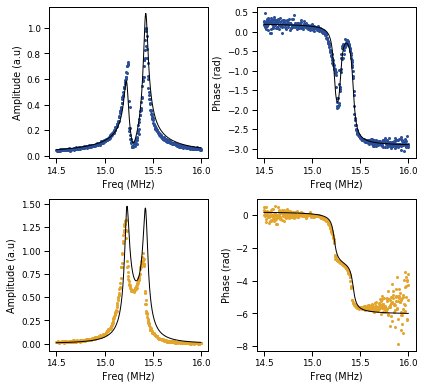

In [42]:
#Plots for paper

sns.set_context('paper')

m1_col = "#2A4F98"
m2_col = "#E4A52D"

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (6,5.5))

ax1.plot(x1/(2*np.pi*10**6), y1, '.', markersize = 4, color = m1_col)
ax1.plot(x1/(2*np.pi*10**6), curve1(x1, m_2, k_2, k_12), '-', color='black', linewidth = 1)
ax1.set_xlabel('Freq (MHz)')
ax1.set_ylabel('Amplitude (a.u)')

ax2.plot(x1/(2*np.pi*10**6), th1, '.', markersize = 4, color = m1_col)
ax2.plot(x1/(2*np.pi*10**6), theta1(x1, m_2, k_2, k_12, d), '-', color='black', linewidth = 1)
ax2.set_xlabel('Freq (MHz)')
ax2.set_ylabel('Phase (rad)')

ax3.plot(x2/(2*np.pi*10**6), y2, '.', markersize = 4, color = m2_col)
ax3.plot(x2/(2*np.pi*10**6), curve2(x2, m_2, k_2, k_12), '-', color='black', linewidth = 1)
ax3.set_xlabel('Freq (MHz)')
ax3.set_ylabel('Amplitude (a.u)')

ax4.plot(x2/(2*np.pi*10**6), th2, '.', markersize = 4, color = m2_col)
ax4.plot(x2/(2*np.pi*10**6), theta2(x2, m_2, k_2, k_12, d), '-', color='black', linewidth = 1)
ax4.set_xlabel('Freq (MHz)')
ax4.set_ylabel('Phase (rad)')

plt.tight_layout()